In [379]:
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import pandas as pd
import contractions
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
df = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/Restaurant_Reviews.tsv?alt=media&token=e8c70b99-384c-4feb-a280-9d12dcf8b58c', sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [6]:
reviews = np.array(df['Review'])
labels = np.array(df['Liked'])

In [24]:
lemmatizer = WordNetLemmatizer()
# Preprocessing
def preprocess_review(review):

    review = contractions.fix(review)
    
    # Convert to lowercase
    review = review.lower()
    
    # Tokenize
    tokens = word_tokenize(review)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    important_stop_words = {
    "not",   # Crucial for negation
    "no",    # Important for negation
    "very",  # Intensifies sentiment
    "too",   # Can indicate excess or negativity
    "just"}  # Often used to soften statements

    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - important_stop_words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

In [25]:
stop_words = set(stopwords.words('english'))

In [26]:
cleaned_reviews = []
# Process each review
for review in reviews:
    cleaned_reviews.append(preprocess_review(review))

In [27]:
cleaned_reviews[:5]

[['wow', '...', 'loved', 'place'],
 ['crust', 'not', 'good'],
 ['not', 'tasty', 'texture', 'just', 'nasty'],
 ['stopped',
  'late',
  'may',
  'bank',
  'holiday',
  'rick',
  'steve',
  'recommendation',
  'loved'],
 ['selection', 'menu', 'great', 'price']]

In [28]:
# Loading the embedding (It is better to download the file and import from the local directory)
model_path = 'https://firebasestorage.googleapis.com/v0/b/common-e8332.appspot.com/o/GoogleNews-vectors-negative300-SLIM.bin?alt=media&token=ce5beeda-f8b4-4d27-99b1-0098b6128372'

# Load the Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [29]:
# Adding special tokens to embedding

# Define the embedding size (for the GoogleNews vectors, it's 300)
embedding_size = word2vec_model.vector_size

# Initialize the <unk> and <pad> vectors (either zero or random)
unk_vector = np.random.uniform(-0.25, 0.25, embedding_size)  # Random initialization
pad_vector = np.zeros(embedding_size)  # Zero vector for padding

# Add <unk> and <pad> to the model's vocabulary
word2vec_model.add_vector('<unk>', unk_vector)
word2vec_model.add_vector('<pad>', pad_vector)

c:\Users\chaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


299568

In [331]:
mean_sequence_length = np.array([len(s.split()) for s in reviews]).mean()
print("Mean Sequence Length:", mean_sequence_length)

Mean Sequence Length: 10.894


In [299]:
sequence_length = 15
# Replace words with indices based on vocabulary and pad sequences
indexed_reviews = []
for review in cleaned_reviews:
    indexed_review = []
    
    # Replace words with indices, use <unk> if word is not in vocabulary
    for word in review:
        if word in word2vec_model.key_to_index:
            indexed_review.append(word2vec_model.key_to_index[word])
        else:
            indexed_review.append(word2vec_model.key_to_index['<unk>'])  # Use <unk> if word is missing

    # Pad with <pad> token if the sequence is shorter than the sequence length
    if len(indexed_review) < sequence_length:
        indexed_review.extend([word2vec_model.key_to_index['<pad>']] * (sequence_length - len(indexed_review)))
    
    # Truncate to the maximum sequence length if too long
    indexed_reviews.append(indexed_review[:sequence_length])

# Convert to numpy array for consistency
indexed_reviews = np.array(indexed_reviews)

In [300]:
indexed_reviews[:2]

array([[ 18099, 299567,   2979,    207, 299568, 299568, 299568, 299568,
        299568, 299568, 299568, 299568, 299568, 299568, 299568],
       [ 24573,     11,    120, 299568, 299568, 299568, 299568, 299568,
        299568, 299568, 299568, 299568, 299568, 299568, 299568]])

In [301]:
indexed_reviews.shape

(1000, 15)

In [302]:
X_train, X_test, y_train, y_test = train_test_split(indexed_reviews, labels, test_size=0.2, random_state=20, stratify=labels)

In [303]:
print('X_train shape (examples x sequence length):', X_train.shape)
print('X_test shape (examples x sequence length))):', X_test.shape)
print("y_train shape (examples x target variables):", y_train.shape)
print("y_test shape (examples x target variables):", y_test.shape)

X_train shape (examples x sequence length): (800, 15)
X_test shape (examples x sequence length))): (200, 15)
y_train shape (examples x target variables): (800,)
y_test shape (examples x target variables): (200,)


In [261]:
class AdamOptimizer:
    def __init__(self, alpha, params, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.moments = []
        self.epoch = 0
        if not params:
            raise Exception("Parameters can't be undefined!")
        for i in range(len(params)):
            self.moments.append(
                {
                    'V': np.zeros_like(params[i]),
                    'S': np.zeros_like(params[i])
                }
            )

    def update(self, params=[], grads=[]):
        params_len = len(params)
        grads_len = len(grads)
        if params_len != grads_len or params_len == 0:
            raise Exception("Empty or Inconsistant Parameters and Gradients List!")

        self.epoch += 1

        for i in range(grads_len):
            # Update biased first moment estimate
            self.moments[i]['V'] = self.beta1 * self.moments[i]['V'] + (1 - self.beta1) * grads[i]
            # Update biased second raw moment estimate (RMSProp part)
            self.moments[i]['S'] = self.beta2 * self.moments[i]['S'] + (1 - self.beta2) * np.square(grads[i])
            # Compute bias-corrected first moment estimate
            VdW_corrected = self.moments[i]['V'] / (1 - self.beta1 ** self.epoch)
            # Compute bias-corrected second raw moment estimate (RMSProp part)
            SdW_corrected = self.moments[i]['S'] / (1 - self.beta2 ** self.epoch)
            # Update parameters
            params[i] -= self.alpha * VdW_corrected / (np.sqrt(SdW_corrected) + self.epsilon)
        
        return params

In [400]:
class RNN:
    '''
    Specifications:
        * Capable of binary classification only
        * Only contains single layer
        * Activation function: tanh
    '''
    def __init__(self, h, T, embedding_matrix):
        self.T = T
        self.d = embedding_matrix.shape[1] # total features
        self.h = h
        self.reset_weights_biases() # Initializing Weights and Biases
        self.embedding_matrix = embedding_matrix
    
    def sigmoid(self, z):
        return (1/(1+np.exp(-z)))
    
    def predict(self, input):
        input = input.T
        M = input.shape[1]
        A = np.zeros((self.h, M))
        for t in range(self.T):
            X = self.embedding_matrix[input[t, :]].T
            A = np.tanh ( self.W_h @ A + self.W_i.T @ X + self.b_h )
        return self.sigmoid( self.w_o.T @ A + self.b_o ).T
    
    def forward_prop(self, input, return_pred=True):
        M = input.shape[1]
        self.A = np.zeros((self.T + 1, self.h, M))
        for t in range(self.T):
            X = self.embedding_matrix[input[t, :]].T
            self.A[t+1] = np.tanh ( self.W_h @ self.A[t] + self.W_i.T @ X + self.b_h )
        if return_pred:
            return self.sigmoid( self.w_o.T @ self.A[-1] + self.b_o )
        return
    
    def backward_prop(self, input, y, y_hat=None):
        M = input.shape[1]
        X = self.embedding_matrix[input[-1, :]].T    # Dim: d x M
        if not y_hat:
            y_hat = self.sigmoid( self.w_o.T @ self.A[-1] + self.b_o )
        if y_hat.shape != y.shape:
            y = y.reshape(y_hat.shape)
        P = y_hat - y
        dL_by_db_o = np.sum(P, axis=1).item()
        dL_by_dw_o = self.A[-1] @ P.T
        P = (np.broadcast_to(P, (self.h, P.size)) * np.broadcast_to(self.w_o, (self.h, M)) * (1 - np.square(self.A[-1])))  # Dim: h x M
        # b_h
        dL_by_db_h = np.sum(P, axis=1).reshape(self.h, 1)
        # W_i
        dL_by_dW_i = X @ P.T
        # W_h
        dL_by_dW_h = P @ self.A[-2].T

        for t in range(-2, -self.T-1, -1):
            X = self.embedding_matrix[input[t, :]].T
            P = (self.W_h.T @ P) * (1 - np.square(self.A[t]))
            # b_h
            dL_by_db_h += np.sum(P, axis=1).reshape(self.h, 1)
            # W_i
            dL_by_dW_i += X @ P.T
            # W_h
            dL_by_dW_h += P @ self.A[t-1].T
        return dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h

    def update_w_sgd(self, dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h, M, lr):
        norm_1 = 1/M
        norm_2 = norm_1 / self.T
        self.b_o = lr * norm_1 * dL_by_db_o
        self.w_o -= lr * norm_1 * dL_by_dw_o
        self.b_h -= lr * norm_2 * dL_by_db_h
        self.W_i -= lr * norm_2 * dL_by_dW_i
        self.W_h -= lr * norm_2 * dL_by_dW_h
        return
    
    def update_w_adam_optimizer(self, dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h, M, lr):
        norm_1 = 1/M
        norm_2 = norm_1 / self.T

        dL_by_db_o *= norm_1
        dL_by_dw_o *= norm_1 
        dL_by_db_h *= norm_2
        dL_by_dW_i *= norm_2
        dL_by_dW_h *= norm_2

        self.b_o, self.w_o, self.b_h, self.W_i, self.W_h = self.optimizer.update(params=[self.b_o, self.w_o, self.b_h, self.W_i, self.W_h], grads=[dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h])
        return

    def reset_weights_biases(self):
        self.W_i = np.random.randn(self.d, self.h) * np.sqrt(2 / (self.h + self.h))
        self.W_h = np.random.randn(self.h, self.h) * np.sqrt(2 / (self.h + self.h))
        self.w_o = np.random.randn(self.h, 1) * np.sqrt(2 / (self.h + 1))
        self.b_h = np.zeros((self.h, 1))
        self.b_o = np.zeros((1, 1))

    def calc_bce(self, y_hat, y):
        # Calculate the BCE for each example
        loss = - (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        
        # Return the total loss (sum of all individual losses)
        return np.sum(loss)
    
    def calc_accuracy(self, y, y_hat):
        wrong_decisions = np.sum( ((y_hat <= 0.5) & (y == 1)) | ((y_hat > 0.5) & (y == 0)))
        M = y.size
        accuracy = (M-wrong_decisions)/M * 100
        return accuracy
    
    def evaluate(self, X, y, reshape=True):
        # Check if the array is 1D
        if y.ndim == 1:
            # Reshape to a column vector with shape (x, 1)
            y = y.reshape(-1, 1)
        if reshape:
            X = X.T
        y_hat = self.forward_prop(X).T
        loss = self.calc_bce(y_hat, y)
        loss *= 1/y.size
        accuracy = self.calc_accuracy(y, y_hat)

        return accuracy.item(), loss.item()
        
    def train(self, X_train, y_train, X_test, y_test, epochs, lr=0.1, verbose=True, adam_optimizer=False):
        # Variable 'X_train, X_test' will come as a matrix with dimensions: M x T (total examples x sequence length)
        if adam_optimizer:
            self.update = self.update_w_adam_optimizer
            self.optimizer = AdamOptimizer(lr, params=[self.b_o, self.w_o, self.b_h, self.W_i, self.W_h])
        else:
            self.update = self.update_w_sgd
        X_train = X_train.T
        X_test = X_test.T
        M = X_train.shape[1]
        training_ds_loss_history = []
        testing_ds_loss_history = []
        epoch_idx = 0
        self.reset_weights_biases()
        while epoch_idx < epochs:
            epoch_idx += 1
            self.forward_prop(X_train, return_pred=False)
            dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h = self.backward_prop(X_train, y_train)
            self.update(dL_by_db_o, dL_by_dw_o, dL_by_db_h, dL_by_dW_i, dL_by_dW_h, M, lr)
            if verbose:
                training_ds_accuracy, training_ds_loss = self.evaluate(X_train, y_train, reshape=False)
                testing_ds_accuracy, testing_ds_loss = self.evaluate(X_test, y_test, reshape=False)
                training_ds_loss_history.append(training_ds_loss)
                testing_ds_loss_history.append(testing_ds_loss)
                print(f"Epoch {epoch_idx:03d} | "
                      f"Train Accuracy: {training_ds_accuracy:.2f}% | Train Loss (BCE): {training_ds_loss:.4f} | "
                      f"Test Accuracy: {testing_ds_accuracy:.2f}% | Test Loss (BCE): {testing_ds_loss:.4f}\n")
        return training_ds_loss_history, testing_ds_loss_history

In [401]:
rnn = RNN(h=64, T=sequence_length, embedding_matrix=word2vec_model.vectors)

In [ ]:
training_ds_loss_history, testing_ds_loss_history = rnn.train(X_train, y_train, X_test, y_test, epochs=50, adam_optimizer=True, lr=0.0005)

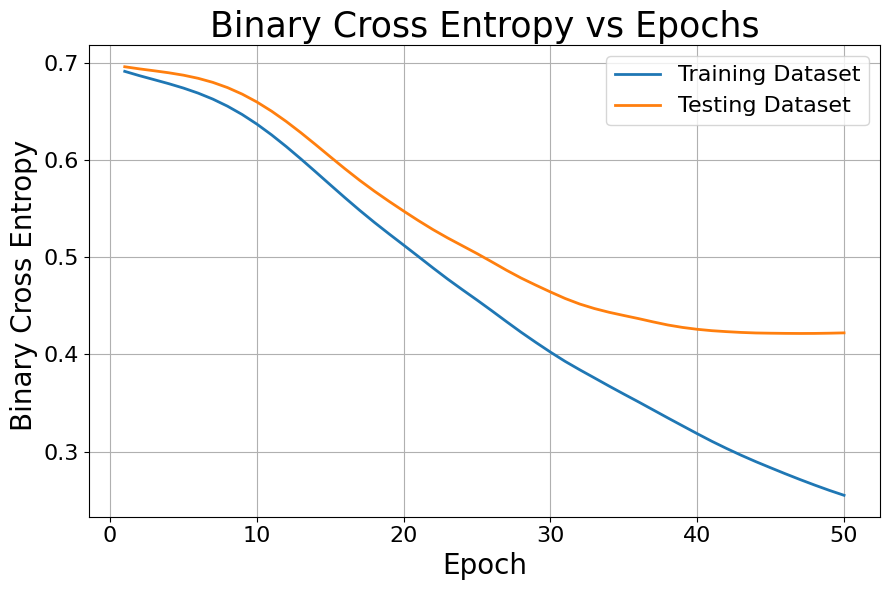

In [432]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Binary Cross Entropy vs Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('bce_rnn.png', dpi=300)
plt.show()

In [421]:
accuracy_train, bce_train = rnn.evaluate(X_train, y_train)
print(f"Training Dataset Accuracy: {accuracy_train:.2f}% | Training Dataset Loss (BCE): {bce_train:.4f}")

Training Dataset Accuracy: 92.62% | Training Dataset Loss (BCE): 0.2550


In [422]:
accuracy_test, bce_test = rnn.evaluate(X_test, y_test)
print(f"Testing Dataset Accuracy: {accuracy_test:.2f}% | Testing Dataset Loss (BCE): {bce_test:.4f}")

Testing Dataset Accuracy: 83.50% | Testing Dataset Loss (BCE): 0.4222


In [429]:
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=accuracy_train,
    title={'text': "Model Accuracy for Training Dataset"},
    number={'suffix': "%"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "green"},
        'steps': [
            {'range': [0, 50], 'color': "lightcoral"},
            {'range': [50, 70], 'color': "#FFA500"},
            {'range': [70, 90], 'color': "yellow"},
            {'range': [90, 100], 'color': "lightgreen"}
        ],
    }
))
fig.update_layout(
    width=600,
    height=400,
)
# fig.write_image("accuracy_train.png", scale=2)
fig.show()


In [430]:
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=accuracy_test,
    title={'text': "Model Accuracy for Testing Dataset"},
    number={'suffix': "%"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "#FFC107"},
        'steps': [
            {'range': [0, 50], 'color': "lightcoral"},
            {'range': [50, 70], 'color': "#FFA500"},
            {'range': [70, 90], 'color': "yellow"},
            {'range': [90, 100], 'color': "lightgreen"}
        ],
    }
))
fig.update_layout(
    width=600,
    height=400,
)
# fig.write_image("accuracy_test.png", scale=2)
fig.show()


In [425]:
# Generating Confusion matrix
y_pred = rnn.predict(X_test)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:\n', cm, '\n')
print('True negative (Actually negative, classified as negative):', cm[0][0])
print('False positive (Actually negative, classified as positive):', cm[0][1])
print('False negative (Actually positive, classified as negative):', cm[1][0])
print('True positive (Actually positive, classified as positive):', cm[1][1])

Confusion Matrix:
 [[87 13]
 [20 80]] 

True negative (Actually negative, classified as negative): 87
False positive (Actually negative, classified as positive): 13
False negative (Actually positive, classified as negative): 20
True positive (Actually positive, classified as positive): 80


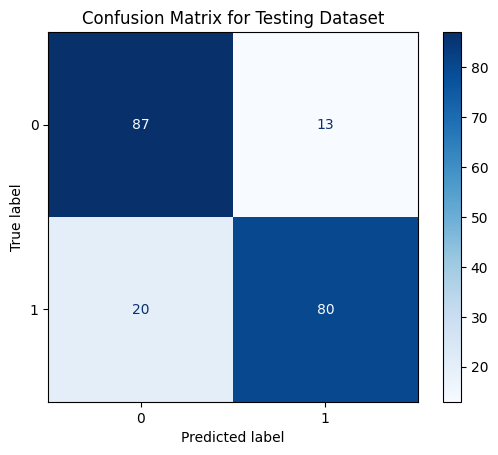

In [431]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Testing Dataset')
# plt.savefig('cm_rnn', dpi=300)
plt.show()

In [427]:
# Generating classification report from scikit-learn
cr = classification_report(y_test, y_pred_classes)
print('Classification Report\n\n', cr)

Classification Report

               precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.86      0.80      0.83       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200

